<a href="https://colab.research.google.com/github/hBar2013/DS-Unit-2-Classification-1/blob/master/kim_lowry_DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [31]:
!pip install category_encoders

In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [0]:
%matplotlib inline
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

Part 1. Prepare to model
Required

Do train/validate/test split. 
Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.

Begin with baselines for classification. Your target to predict is shot_made_flag. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?

Use Ordinal Encoding or One-Hot Encoding, for the categorical features you select.

Train a Random Forest or Logistic Regression with the features you select.

In [0]:
df['period'] =  df['period'].apply(str)

In [92]:
df.describe(exclude=np.number).T

,count,unique,top,freq
player_name,13958,1,Stephen Curry,13958
period,13958,6,3,4129
action_type,13958,53,Jump Shot,6657
shot_type,13958,2,2PT Field Goal,7135
shot_zone_basic,13958,7,Above the Break 3,5695
shot_zone_area,13958,6,Center(C),5987
shot_zone_range,13958,5,24+ ft.,6721
htm,13958,32,GSW,6871
vtm,13958,32,GSW,7087
season_type,13958,2,Regular Season,11846


In [0]:
train = df['2009-10-01':'2017-06-30']
val = df['2017-10-01':'2018-06-30']
test  = df['2018-10-01':]

In [0]:
test.isnull().sum()

In [0]:
X_train = train.drop(['shot_made_flag'], axis=1)

In [0]:
y_train = train['shot_made_flag']
X_val = val.drop(['shot_made_flag'], axis=1)
y_val = val['shot_made_flag']

In [0]:
X_test = test.drop(['shot_made_flag'], axis=1)
y_test = test['shot_made_flag']

In [48]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11081, 18), (1168, 18), (11081,), (1168,))

In [49]:

y_train.value_counts(normalize=True)

0    0.527209
1    0.472791
Name: shot_made_flag, dtype: float64

Baseline  for class is y_pred = 0.527209

In [0]:
df.dtypes


In [0]:
cat_features = ['shot_type', 'shot_zone_basic', 'shot_zone_area', 
               'shot_zone_range', 'season_type', 'period']

In [0]:
num_features = ['minutes_remaining', 'seconds_remaining', 'shot_distance', 
                'loc_x', 'loc_y', 'scoremargin_before_shot']

In [0]:
features = cat_features + num_features

In [0]:
X_train_subset = X_train[features]
X_val_subset = X_val[features]

In [0]:
X_test_subset = X_test[features]

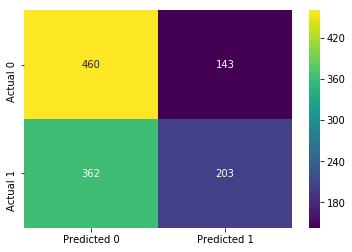

In [76]:
pipeline = make_pipeline(
          #ce.OrdinalEncoder(),
          ce.OneHotEncoder(),
          SimpleImputer(strategy='median'),
          StandardScaler(),
          LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
          #RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
    )

pipeline.fit(X_train_subset, y_train)
y_pred = pipeline.predict(X_val_subset)
    
labels = unique_labels(y_val)
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}' for label in labels]
table = pd.DataFrame(confusion_matrix(y_val, y_pred), 
                         columns=columns, index=index)
sns.heatmap(table, annot=True, fmt='d', cmap='viridis');
     

In [89]:
print('Logistic Regression Accuracy: ', accuracy_score(y_val, y_pred)) 
print('Logistic Regression Report: \n', classification_report(y_val, y_pred))


Logistic Regression Accuracy:  0.5676369863013698
Logistic Regression Report: 
               precision    recall  f1-score   support

           0       0.56      0.76      0.65       603
           1       0.59      0.36      0.45       565

    accuracy                           0.57      1168
   macro avg       0.57      0.56      0.55      1168
weighted avg       0.57      0.57      0.55      1168



In [0]:
y_pred_test = pipeline.predict(X_test_subset)

In [98]:
print('Logistic Regression Test Accuracy: ', accuracy_score(y_test, y_pred))

Logistic Regression Test Accuracy:  0.5781158572264482


In [80]:
pipeline.named_steps

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'onehotencoder': OneHotEncoder(cols=['shot_type', 'shot_zone_basic', 'shot_zone_area',
                     'shot_zone_range', 'season_type', 'period'],
               drop_invariant=False, handle_missing='value',
               handle_unknown='value', return_df=True, use_cat_names=False,
               verbose=0),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='median', verbose=0),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [0]:
encoder = pipeline.named_steps['onehotencoder']
model = pipeline.named_steps['logisticregression']
feature_names = encoder.transform(X_val_subset).columns
importances = pd.Series(model.coef_[0], feature_names)


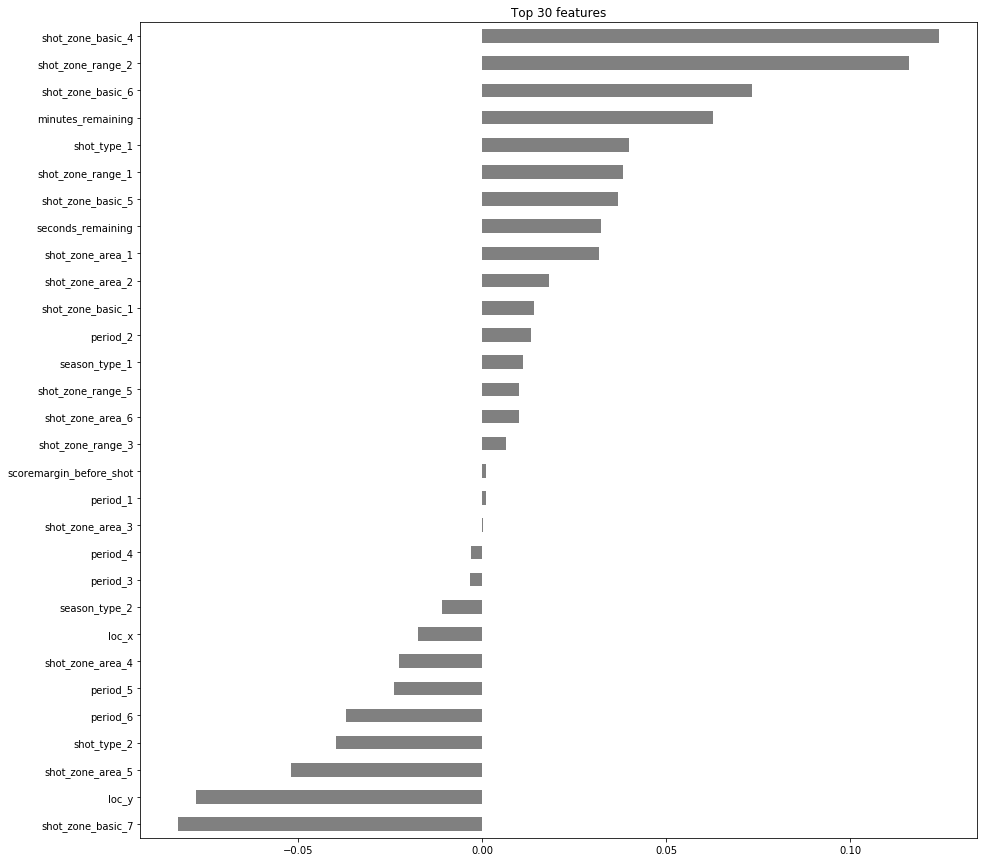

In [88]:
n = 30
plt.figure(figsize=(15,30/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [100]:
#Example Confusion Matrix Accuracy
correct_predictions = 85 + 36
total_predictions = correct_predictions + 8 + 58
accuracy = correct_predictions / total_predictions
accuracy

0.6470588235294118

In [105]:
#Example Confusion Matrix  Negative Precision
correct_predictions_negative = 85
total_predictions_negative = 85 + 8
negative_precision = correct_predictions_negative / total_predictions_negative
negative_precision

0.9139784946236559

In [113]:
#Example Confusion Matrix Positive Precision
correct_predictions_positive = 36
total_predictions_positive = 36 + 58
positive_precision = correct_predictions_positive / total_predictions_positive
positive_precision

0.3829787234042553

In [109]:
#Example Confusion Matrix  Negative Recall
actual_negative = 85 + 58
negative_recall = correct_predictions_negative / actual_negative
negative_recall

0.5944055944055944

In [112]:
#Example Confusion Matrix Positive Recall
actual_positive = 8 + 36
positive_recall = correct_predictions_positive / actual_positive
positive_recall

0.8181818181818182